## Import Libraries

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder
from itertools import product
import sklearn
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

## Load DataSet

In [119]:
sales = pd.read_csv('DataSet/sales_train.csv')
item_categories = pd.read_csv('DataSet/item_categories.csv')
items = pd.read_csv('DataSet/items.csv')
shops = pd.read_csv('DataSet/shops.csv')
test = pd.read_csv('DataSet/test.csv')

### Checking Null Values

In [120]:
print(sales.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


### Extract the year and month from date column into independent columns

In [121]:
df = sales[['date','date_block_num','item_cnt_day']].copy()

In [122]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.drop('date', axis=1, inplace=True)

In [123]:
df

,date_block_num,item_cnt_day,year,month
0,0,1.0,2013,1
1,0,1.0,2013,1
2,0,-1.0,2013,1
3,0,1.0,2013,1
4,0,1.0,2013,1
...,...,...,...,...
2935844,33,1.0,2015,10
2935845,33,1.0,2015,10
2935846,33,1.0,2015,10
2935847,33,1.0,2015,10


In [124]:
df = df.groupby('date_block_num', as_index=False).agg({
    'year': 'first',
    'month': 'first',
    'item_cnt_day': 'sum'
}).rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=False)


In [125]:
df

,date_block_num,year,month,item_cnt_month
0,0,2013,1,131479.0
1,1,2013,2,128090.0
2,2,2013,3,147142.0
3,3,2013,4,107190.0
4,4,2013,5,106970.0
5,5,2013,6,125381.0
6,6,2013,7,116966.0
7,7,2013,8,125291.0
8,8,2013,9,133332.0
9,9,2013,10,127541.0


### Plotting Graphs of Sales according to month

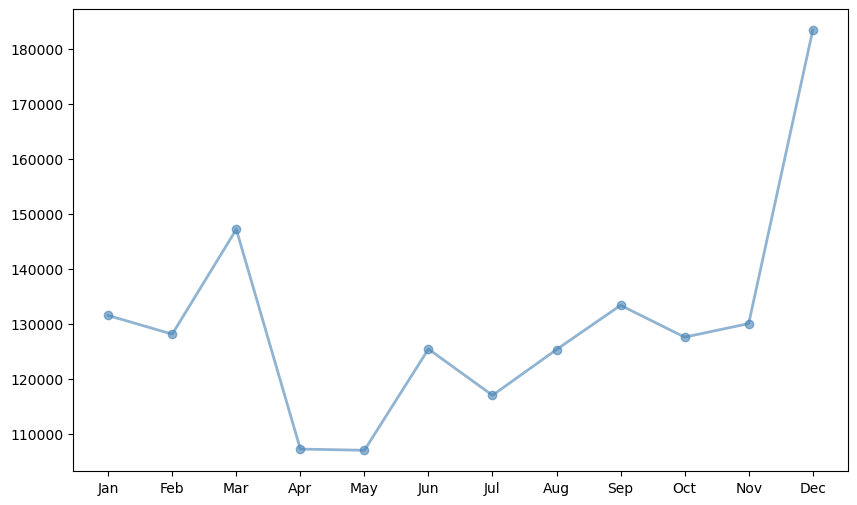

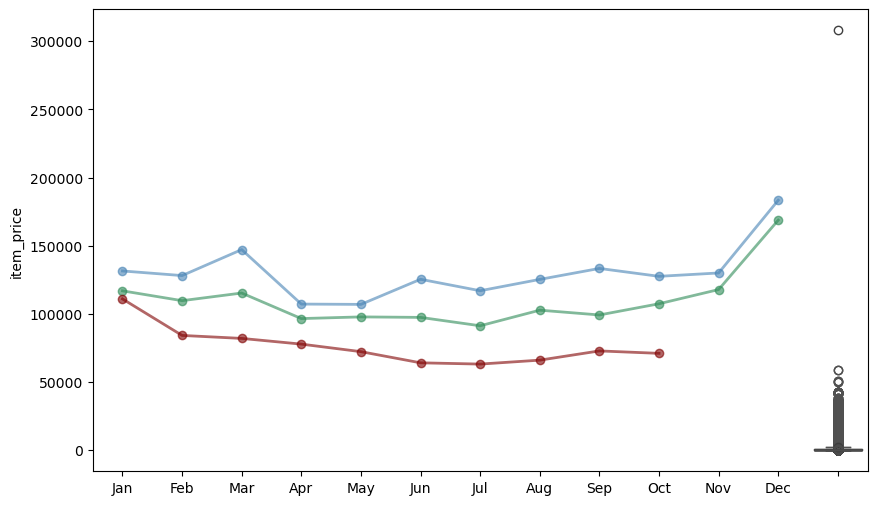

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

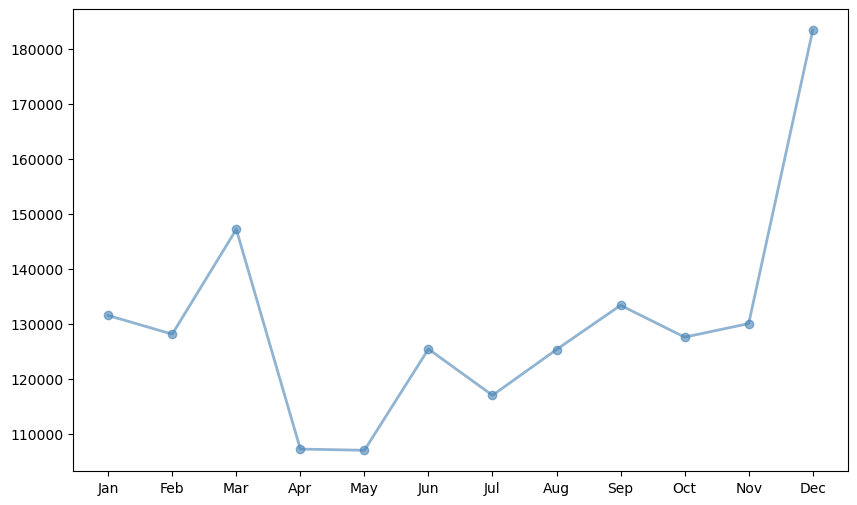

In [126]:
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
LINEWIDTH=2
ALPHA=.6
plt.figure(figsize=(10, 6))
# plot the sales of 2013
plt.plot(MONTHS, df[df['year']==2013].item_cnt_month,'-o',color='steelblue',linewidth=LINEWIDTH,alpha=ALPHA,label='2013')
plt.show()

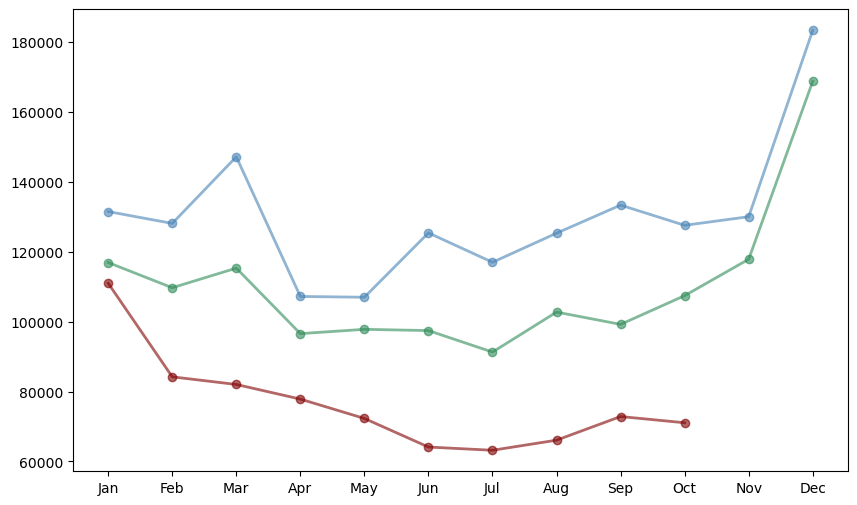

In [127]:
plt.figure(figsize=(10, 6))
# plot the sales of 2013
plt.plot(MONTHS, df[df.year==2013].item_cnt_month,'-o',color='steelblue',linewidth=LINEWIDTH,alpha=ALPHA,label='2013')
# plot the sales of 2014
plt.plot(MONTHS, df[df.year==2014].item_cnt_month,'-o',color='seagreen',linewidth=LINEWIDTH,alpha=ALPHA,label='2014')
# plot the sales of 2015
plt.plot(MONTHS[:10], df[df.year==2015].item_cnt_month,'-o',color='maroon',linewidth=LINEWIDTH,alpha=ALPHA,label='2015')
plt.show()

### Best selling categories for each year

In [129]:
# Best selling cateogries for each year
N=15

def get_ratio(year,top_n, N):
  total = df.loc[year].item_cnt_year.sum()
  ratio = top_n/total*100
  return "{0}: the total of the top {1} best selling items is {2} over a total of {3} for that year, which represents {4:.2f}%".format(year, N, top_n, total, ratio)

df = sales[['date','item_id','item_cnt_day']].copy()
cats = item_categories.copy()

### Extract the year from date column

In [130]:
# Extract the year from date column
df['year'] = pd.to_datetime(df['date'], format='%d.%m.%Y').dt.year
df.drop('date', axis=1, inplace=True)
df.item_cnt_day  = df.item_cnt_day.astype(int)

In [13]:
df

,item_id,item_cnt_day,year
0,22154,1,2013
1,2552,1,2013
2,2552,-1,2013
3,2554,1,2013
4,2555,1,2013
...,...,...,...
2935844,7409,1,2015
2935845,7460,1,2015
2935846,7459,1,2015
2935847,7440,1,2015


### Remove returns
- where the item count is negative which means order is returned

In [131]:
# remove returns
df = df[df.item_cnt_day > 0]

In [132]:
df

,item_id,item_cnt_day,year
0,22154,1,2013
1,2552,1,2013
3,2554,1,2013
4,2555,1,2013
5,2564,1,2013
...,...,...,...
2935844,7409,1,2015
2935845,7460,1,2015
2935846,7459,1,2015
2935847,7440,1,2015


### Add the categories of each item 

In [133]:
# ADd the categories of each item
df= df.merge(items[['item_id','item_category_id']], how = 'left', on = 'item_id')

In [134]:
df

,item_id,item_cnt_day,year,item_category_id
0,22154,1,2013,37
1,2552,1,2013,58
2,2554,1,2013,58
3,2555,1,2013,56
4,2564,1,2013,59
...,...,...,...,...
2928488,7409,1,2015,55
2928489,7460,1,2015,55
2928490,7459,1,2015,55
2928491,7440,1,2015,57


### Number of categories sold each year

In [135]:
# number of categories sold each year
df = df.groupby(['year','item_category_id'], as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns={'item_cnt_day': 'item_cnt_year'}, inplace=False)

In [136]:
df

,year,item_category_id,item_cnt_year
0,2013,0,3
1,2013,1,2
2,2013,2,11386
3,2013,3,6603
4,2013,4,1907
...,...,...,...
211,2015,79,7268
212,2015,80,6137
213,2015,81,1
214,2015,82,50


In [137]:
# Top N categories sold
top = df.groupby('year').apply(lambda x: x.nlargest(N, 'item_cnt_year')).reset_index(drop=True)

C:\Users\akkan\AppData\Local\Temp\ipykernel_8928\3662005622.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top = df.groupby('year').apply(lambda x: x.nlargest(N, 'item_cnt_year')).reset_index(drop=True)


In [138]:
top

,year,item_category_id,item_cnt_year
0,2013,40,331230
1,2013,30,235655
2,2013,55,155136
3,2013,19,134813
4,2013,37,86898
5,2013,28,77303
6,2013,23,70208
7,2013,71,63928
8,2013,65,25309
9,2013,75,24300


In [139]:
top = top.merge(item_categories[['item_category_id','item_category_name']], how = 'left', on = 'item_category_id')

### Remove outliers

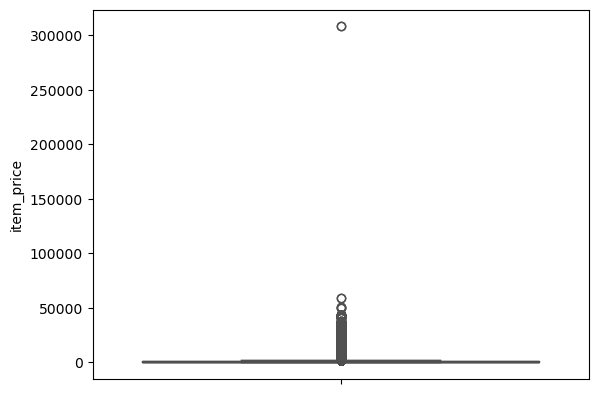

In [141]:
# removing outliers
sns.boxplot(sales['item_price'])
plt.show()

In [142]:
sales = sales[(sales.item_price<100000)&(sales.item_price>0)]

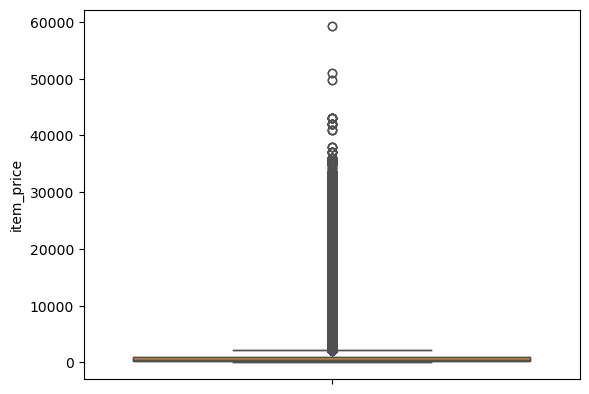

In [144]:
sns.boxplot(sales['item_price'])
plt.show()

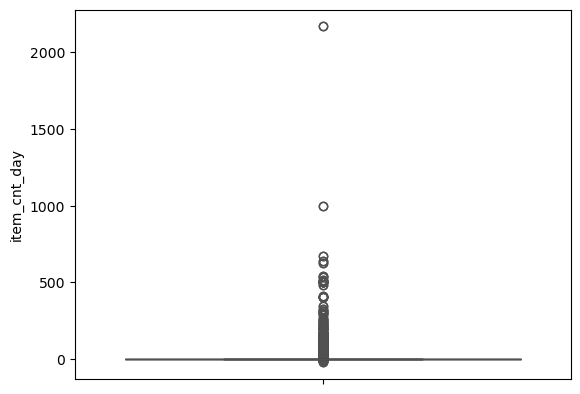

In [146]:
# outliers in item_cnt_day
sns.boxplot(sales['item_cnt_day'])
plt.show()

In [147]:
sales = sales[(sales.item_cnt_day>0)&(sales.item_cnt_day<1000)]

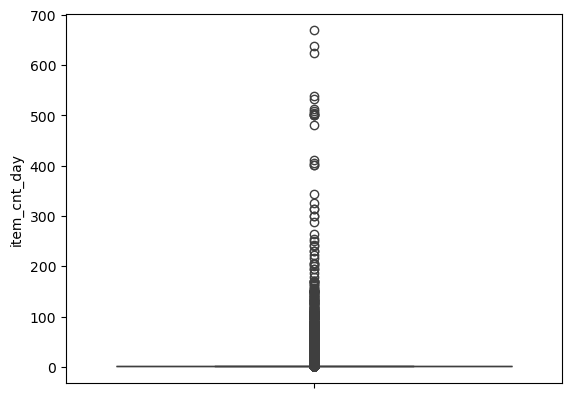

In [148]:
sns.boxplot(sales['item_cnt_day'])
plt.show()

### Checking duplicates

In [150]:
# checking and removing duplicates
sales.duplicated().sum()

6

In [151]:
all_duplicates = sales[sales.duplicated(keep=False)]

In [152]:
all_duplicates

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.0,1.0
76962,05.01.2013,0,54,20130,149.0,1.0
1435365,23.02.2014,13,50,3423,999.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496765,23.03.2014,14,21,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671872,01.05.2014,16,50,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866322,12.07.2014,18,25,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0


In [153]:
# remove these duplicates
sales = sales.drop_duplicates()

In [154]:
test.duplicated().sum()

0

In [155]:
test.loc[test.shop_id==10]

,ID,shop_id,item_id
30600,30600,10,5037
30601,30601,10,5320
30602,30602,10,5233
30603,30603,10,5232
30604,30604,10,5268
...,...,...,...
35695,35695,10,18454
35696,35696,10,16188
35697,35697,10,15757
35698,35698,10,19648


In [156]:
test.loc[test.shop_id==11]

,ID,shop_id,item_id


### Correct the name of the shop
- The first part of the shop_name is the city , the second part is the category i.e. shopping center name

In [158]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name"] = 'СергиевПосад ТЦ "7Я"'
shops['shop_city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['shop_category'] = shops.shop_name.str.split(' ').map(lambda x: x[1:])
shops.shop_category = shops.shop_category.apply(' '.join)
shops.loc[shops.shop_city == "!Якутск", "shop_city"] = "Якутск"

In [159]:
shops.head()

,shop_name,shop_id,shop_city,shop_category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,"Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,"ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега""",2,Адыгея,"ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,"ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,"ТЦ ""Волга Молл"""


### Feature Encoding

In [160]:
encoder = LabelEncoder()

In [161]:
shops['shop_city'] = LabelEncoder().fit_transform(shops.shop_city)
shops['shop_category'] = LabelEncoder().fit_transform(shops.shop_category)

In [162]:
shops = shops[['shop_id','shop_category','shop_city']]
shops.head()

,shop_id,shop_category,shop_city
0,0,5,29
1,1,50,29
2,2,38,0
3,3,15,1
4,4,32,2


### Create sub types in item categories

In [165]:
# create sub types in item categories
item_categories['category_type'] = item_categories.item_category_name.apply(lambda x:x.split(" ")[0]).astype(str)


In [166]:
item_categories

,item_category_name,item_category_id,category_type
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


- Category_type "Gamming" and "accessories" becomes "Games"

In [167]:
# The category_type "Gamming" and "accesoires" becomes "Games"
item_categories.loc[(item_categories.category_type == 'Игровые') | (item_categories.category_type == "Аксессуары"), "category_type"] = "Игры"

In [168]:
item_categories["split"] = item_categories.item_category_name.apply(lambda x: x.split("-"))
item_categories["category_subtype"] = item_categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [169]:
item_categories

,item_category_name,item_category_id,category_type,split,category_subtype
0,PC - Гарнитуры/Наушники,0,PC,"[PC , Гарнитуры/Наушники]",Гарнитуры/Наушники
1,Аксессуары - PS2,1,Игры,"[Аксессуары , PS2]",PS2
2,Аксессуары - PS3,2,Игры,"[Аксессуары , PS3]",PS3
3,Аксессуары - PS4,3,Игры,"[Аксессуары , PS4]",PS4
4,Аксессуары - PSP,4,Игры,"[Аксессуары , PSP]",PSP
...,...,...,...,...,...
79,Служебные,79,Служебные,[Служебные],Служебные
80,Служебные - Билеты,80,Служебные,"[Служебные , Билеты]",Билеты
81,Чистые носители (шпиль),81,Чистые,[Чистые носители (шпиль)],Чистые носители (шпиль)
82,Чистые носители (штучные),82,Чистые,[Чистые носители (штучные)],Чистые носители (штучные)


### Feature Encoding

In [170]:
encoder = LabelEncoder()
item_categories['category_type'] = encoder.fit_transform(item_categories.category_type)
item_categories['category_subtype'] = encoder.fit_transform(item_categories.category_subtype)
item_categories = item_categories[['item_category_id','category_type','category_subtype']]

In [171]:
item_categories.head()

,item_category_id,category_type,category_subtype
0,0,0,29
1,1,3,9
2,2,3,10
3,3,3,11
4,4,3,13


### Compute Monthly Sales

In [ ]:
# compute monthly sales
sales = sales.groupby(['date_block_num', 'shop_id','item_id'], as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=False)

In [50]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [51]:
test['date_block_num'] = 34
test['item_cnt_month'] = 0

In [52]:
test

,ID,shop_id,item_id,date_block_num,item_cnt_month
0,0,5,5037,34,0
1,1,5,5320,34,0
2,2,5,5233,34,0
3,3,5,5232,34,0
4,4,5,5268,34,0
...,...,...,...,...,...
214195,214195,45,18454,34,0
214196,214196,45,16188,34,0
214197,214197,45,15757,34,0
214198,214198,45,19648,34,0


In [53]:
del test['ID']

In [54]:
test

,shop_id,item_id,date_block_num,item_cnt_month
0,5,5037,34,0
1,5,5320,34,0
2,5,5233,34,0
3,5,5232,34,0
4,5,5268,34,0
...,...,...,...,...
214195,45,18454,34,0
214196,45,16188,34,0
214197,45,15757,34,0
214198,45,19648,34,0


In [55]:
df = pd.concat([sales, test],ignore_index=True)

In [56]:
df

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1822419,34,45,18454,0.0
1822420,34,45,16188,0.0
1822421,34,45,15757,0.0
1822422,34,45,19648,0.0


In [57]:
sales

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1608219,33,59,22087,6.0
1608220,33,59,22088,2.0
1608221,33,59,22091,1.0
1608222,33,59,22100,1.0


In [58]:
# create a feature matrix
matrix = []
for i in range(35):
    tmp = df[df.date_block_num==i]
    matrix.append(np.array(list(product([i], tmp.shop_id.unique(), tmp.item_id.unique())), dtype='int16'))

In [59]:
matrix

[array([[    0,     0,    32],
        [    0,     0,    33],
        [    0,     0,    35],
        ...,
        [    0,    59, 18018],
        [    0,    59, 18268],
        [    0,    59, 20178]], dtype=int16),
 array([[    1,     0,    30],
        [    1,     0,    31],
        [    1,     0,    32],
        ...,
        [    1,    59, 16291],
        [    1,    59, 20152],
        [    1,    59, 20931]], dtype=int16),
 array([[    2,     2,    30],
        [    2,     2,    31],
        [    2,     2,   482],
        ...,
        [    2,    59, 20940],
        [    2,    59, 20943],
        [    2,    59, 21838]], dtype=int16),
 array([[    3,     2,    31],
        [    3,     2,   464],
        [    3,     2,   482],
        ...,
        [    3,    59, 12437],
        [    3,    59, 16358],
        [    3,    59, 21985]], dtype=int16),
 array([[    4,     2,   482],
        [    4,     2,   484],
        [    4,     2,   485],
        ...,
        [    4,    59, 13838],
       

In [60]:
# turn the grid into dataframe
matrix = pd.DataFrame(np.vstack(matrix),columns=['date_block_num','shop_id','item_id'])

In [61]:
matrix

,date_block_num,shop_id,item_id
0,0,0,32
1,0,0,33
2,0,0,35
3,0,0,43
4,0,0,51
...,...,...,...
11098703,34,45,18454
11098704,34,45,16188
11098705,34,45,15757
11098706,34,45,19648


In [62]:
# add the features from sales data to the matrix
matrix = matrix.merge(df, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

In [63]:
# merge features from shops, items and item categories
matrix = matrix.merge(shops, on ='shop_id', how = 'left')
matrix = matrix.merge(items[['item_id','item_category_id']], on = 'item_id', how = 'left')
matrix = matrix.merge(item_categories, on = 'item_category_id', how = 'left')

In [64]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,category_type,category_subtype
0,0,0,32,6.0,5,29,40,5,4
1,0,0,33,3.0,5,29,37,5,1
2,0,0,35,1.0,5,29,40,5,4
3,0,0,43,1.0,5,29,40,5,4
4,0,0,51,2.0,5,29,57,7,8
...,...,...,...,...,...,...,...,...,...
11098703,34,45,18454,0.0,41,20,55,7,2
11098704,34,45,16188,0.0,41,20,64,8,42
11098705,34,45,15757,0.0,41,20,55,7,2
11098706,34,45,19648,0.0,41,20,40,5,4


In [65]:
# add month
matrix['month']= matrix.date_block_num%12
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)

In [66]:
# Set columns types to control the matrix' size
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix['month'] = matrix['month'].astype(np.int8)
matrix['item_cnt_month'] = matrix['item_cnt_month'].astype(np.int32)
matrix['shop_category'] = matrix['shop_category'].astype(np.int8)
matrix['shop_city'] = matrix['shop_city'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['category_type'] = matrix['category_type'].astype(np.int8)
matrix['category_subtype'] = matrix['category_subtype'].astype(np.int8)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,category_type,category_subtype,month
0,0,0,32,6,5,29,40,5,4,0
1,0,0,33,3,5,29,37,5,1,0
2,0,0,35,1,5,29,40,5,4,0
3,0,0,43,1,5,29,40,5,4,0
4,0,0,51,2,5,29,57,7,8,0
...,...,...,...,...,...,...,...,...,...,...
11098703,34,45,18454,0,41,20,55,7,2,10
11098704,34,45,16188,0,41,20,64,8,42,10
11098705,34,45,15757,0,41,20,55,7,2,10
11098706,34,45,19648,0,41,20,40,5,4,10


In [67]:
# feature engineering ==> Add lag features

In [68]:
def lag_features(df,lags,col):
  print(col)
  for i in lags:
    shifted = df[['date_block_num','shop_id','item_id',col]].copy()
    shifted.columns = ['date_block_num', 'shop_id','item_id',col+'_lag_'+str(i)]
    shifted['date_block_num'] += i
    df = pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
  return df

In [69]:
df

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1822419,34,45,18454,0.0
1822420,34,45,16188,0.0
1822421,34,45,15757,0.0
1822422,34,45,19648,0.0


In [70]:
# lag the target item_cnt_month
matrix = lag_features(matrix,[1,2,3,4,5,12],'item_cnt_month')

item_cnt_month


In [71]:
# shop/date_block_num aggregates lags
gb = matrix.groupby(['shop_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_shop'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
matrix = lag_features(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_shop')
matrix.drop('cnt_block_shop', axis=1, inplace=True)

cnt_block_shop


In [72]:
# item/date_block_num aggregates lags
gb = matrix.groupby(['item_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_item'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
matrix = lag_features(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_item')
matrix.drop('cnt_block_item', axis=1, inplace=True)

cnt_block_item


In [73]:
# category/date_block_num aggregates lags
gb = matrix.groupby(['category_type', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_category'}, inplace=False)
matrix = matrix.merge(gb, how='left', on=['category_type', 'date_block_num']).fillna(0)
matrix = lag_features(matrix, [1, 2, 3, 4, 5, 12], 'cnt_block_category')
matrix.drop('cnt_block_category', axis=1, inplace=True)

cnt_block_category


In [74]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'shop_category', 'shop_city', 'item_category_id', 'category_type',
       'category_subtype', 'month', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_12', 'cnt_block_shop_lag_1',
       'cnt_block_shop_lag_2', 'cnt_block_shop_lag_3', 'cnt_block_shop_lag_4',
       'cnt_block_shop_lag_5', 'cnt_block_shop_lag_12', 'cnt_block_item_lag_1',
       'cnt_block_item_lag_2', 'cnt_block_item_lag_3', 'cnt_block_item_lag_4',
       'cnt_block_item_lag_5', 'cnt_block_item_lag_12',
       'cnt_block_category_lag_1', 'cnt_block_category_lag_2',
       'cnt_block_category_lag_3', 'cnt_block_category_lag_4',
       'cnt_block_category_lag_5', 'cnt_block_category_lag_12'],
      dtype='object')

In [83]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_val = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val =  matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [84]:
X_train.drop('date_block_num', axis=1, inplace=True)
X_val.drop('date_block_num', axis=1, inplace=True)
X_test.drop('date_block_num', axis=1, inplace=True)

In [107]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)


(10646424, 32)
(10646424,)
(238084, 32)
(238084,)
(214200, 32)


In [85]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val,label=y_val)

In [87]:
params ={'colsample_bytree': 0.8406368905921987,
         'device': 'cuda',
         'eval_metric': 'rmse',
         'learning_rate': 0.023622088178310074,
         'max_bin': 256,
         'max_depth': 12,
         'min_child_weight': 1.9311905509233425,
         'n_estimators': 700,
         'nthread': 2,
         'reg_lambda': 0.004641439538226732,
         'subsample': 0.8055867639368266,
         'tree_method': 'hist',
         'n_jobs':-1}

In [114]:
# # Training the model
model=xgb.train(params,dtrain,num_boost_round=1000, evals=[(dtrain,'train'),(dtest,'test')],early_stopping_rounds=100)

c:\Users\akkan\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:1.21393	test-rmse:1.12855
[1]	train-rmse:1.20153	test-rmse:1.11907
[2]	train-rmse:1.18993	test-rmse:1.11153
[3]	train-rmse:1.17836	test-rmse:1.10314
[4]	train-rmse:1.16752	test-rmse:1.09603
[5]	train-rmse:1.15650	test-rmse:1.08832
[6]	train-rmse:1.14638	test-rmse:1.08088
[7]	train-rmse:1.13600	test-rmse:1.07367
[8]	train-rmse:1.12636	test-rmse:1.06680
[9]	train-rmse:1.11680	test-rmse:1.06091
[10]	train-rmse:1.10778	test-rmse:1.05508
[11]	train-rmse:1.09878	test-rmse:1.04900
[12]	train-rmse:1.09069	test-rmse:1.04392
[13]	train-rmse:1.08262	test-rmse:1.03909
[14]	train-rmse:1.07477	test-rmse:1.03359
[15]	train-rmse:1.06690	test-rmse:1.02855
[16]	train-rmse:1.05945	test-rmse:1.02419
[17]	train-rmse:1.05243	test-rmse:1.02014
[18]	train-rmse:1.04551	test-rmse:1.01595
[19]	train-rmse:1.03914	test-rmse:1.01226
[20]	train-rmse:1.03250	test-rmse:1.00850
[21]	train-rmse:1.02601	test-rmse:1.00498
[22]	train-rmse:1.02013	test-rmse:1.00115
[23]	train-rmse:1.01409	test-rmse:0.99779
[2

In [90]:
train_pred = model.predict(dtrain)
rmse = np.sqrt(mean_squared_error(y_train,train_pred))
print(rmse)

0.8408624318913379


In [94]:
import xgboost as xgb

In [108]:
X_test.shape

(214200, 32)

In [95]:
dtest1 = xgb.DMatrix(X_test)

In [109]:
y_test_pred = model.predict(dtest1).clip(0,20)

In [110]:
len(y_test_pred)

214200

In [103]:
test_df = pd.read_csv('DataSet/test.csv')

In [105]:
test_df.shape

(214200, 3)

In [111]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test_pred
})

In [113]:
submission.to_csv('submission_file.csv',index=False)